# Generate data from ARIMA - HMM mixture models
Generate models with data partially from ARIMA and partially from HMM model. Requires loading HMM models from a file.

## Setup

In [33]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import pickle
from ARIMA import *
from hmmlearn import hmm
from sacf import *
from model_class import *

# Select file with data generated from HMM - it is not important which exactly, it 
# must only contain any list of hmm.BaseHMM instances
FILE_STORING_HMM_MODELS = "generated_data_set2/HMM_GMM_data_ntrain5_min20_max50_1659090778.pkl"

DATA_DIR = "./generated_data_set2"
GENERATING_MODEL_NAME = "ARIMA_HMM_mix"
N_TRAIN_SAMPLES_PER_MODEL = 30
N_TEST_SAMPLES_PER_MODEL = 30
MIN_SAMPLE_LEN = 50
MAX_SAMPLE_LEN = 150

FILENAME_SUFFIX = f"{GENERATING_MODEL_NAME}_data_ntrain{N_TRAIN_SAMPLES_PER_MODEL}_min{MIN_SAMPLE_LEN}_max{MAX_SAMPLE_LEN}"
DESCRIPTION = "Mixture of ARIMA and HMM models"

time_index = int(time.time())

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

## Load HMM models

In [34]:
with open(FILE_STORING_HMM_MODELS, "rb") as f:
    data_hmm = pickle.load(f)
    HMM_models_lst = data_hmm["models_lst"]

## Define models

In [35]:
model1 = ARIMA_HMM_model(np.array([0.8]), np.array([0.0]), t = -5, HMM_instance= HMM_models_lst[0])
model2 = ARIMA_HMM_model(np.array([0.8]), np.array([2.0]), t = 1, HMM_instance= HMM_models_lst[1], tau = 0.8)
model3 = ARIMA_HMM_model(np.array([0.8]), np.array([4.0]), t = 3, HMM_instance= HMM_models_lst[6], tau = 0.8)

model4 = ARIMA_HMM_model(np.array([-0.3]), np.array([0.0]), t = 1, mu = 5, sigma = 10, HMM_instance= HMM_models_lst[3])
model5 = ARIMA_HMM_model(np.array([-0.3]), np.array([4.0]), t = 1, HMM_instance= HMM_models_lst[6], tau = 0.8)
model6 = ARIMA_HMM_model(np.array([-0.3]), np.array([8.0]), t = 0, HMM_instance= HMM_models_lst[5])

model7 = ARIMA_HMM_model(np.array([0.1]), np.array([0.0]), t = 4, HMM_instance= HMM_models_lst[6])
model8 = ARIMA_HMM_model(np.array([0.4]), np.array([2.0, 3.0, -0.8]), t = 1, HMM_instance= HMM_models_lst[7])
model9 = ARIMA_HMM_model(np.array([0.1]), np.array([2.0, -5.0]), t = 3, sigma = 4, HMM_instance= HMM_models_lst[8], tau = 0.6)


models_lst = [model1, model2, model3, model4, model5, model6, model7, model8, model9]

## Show plots

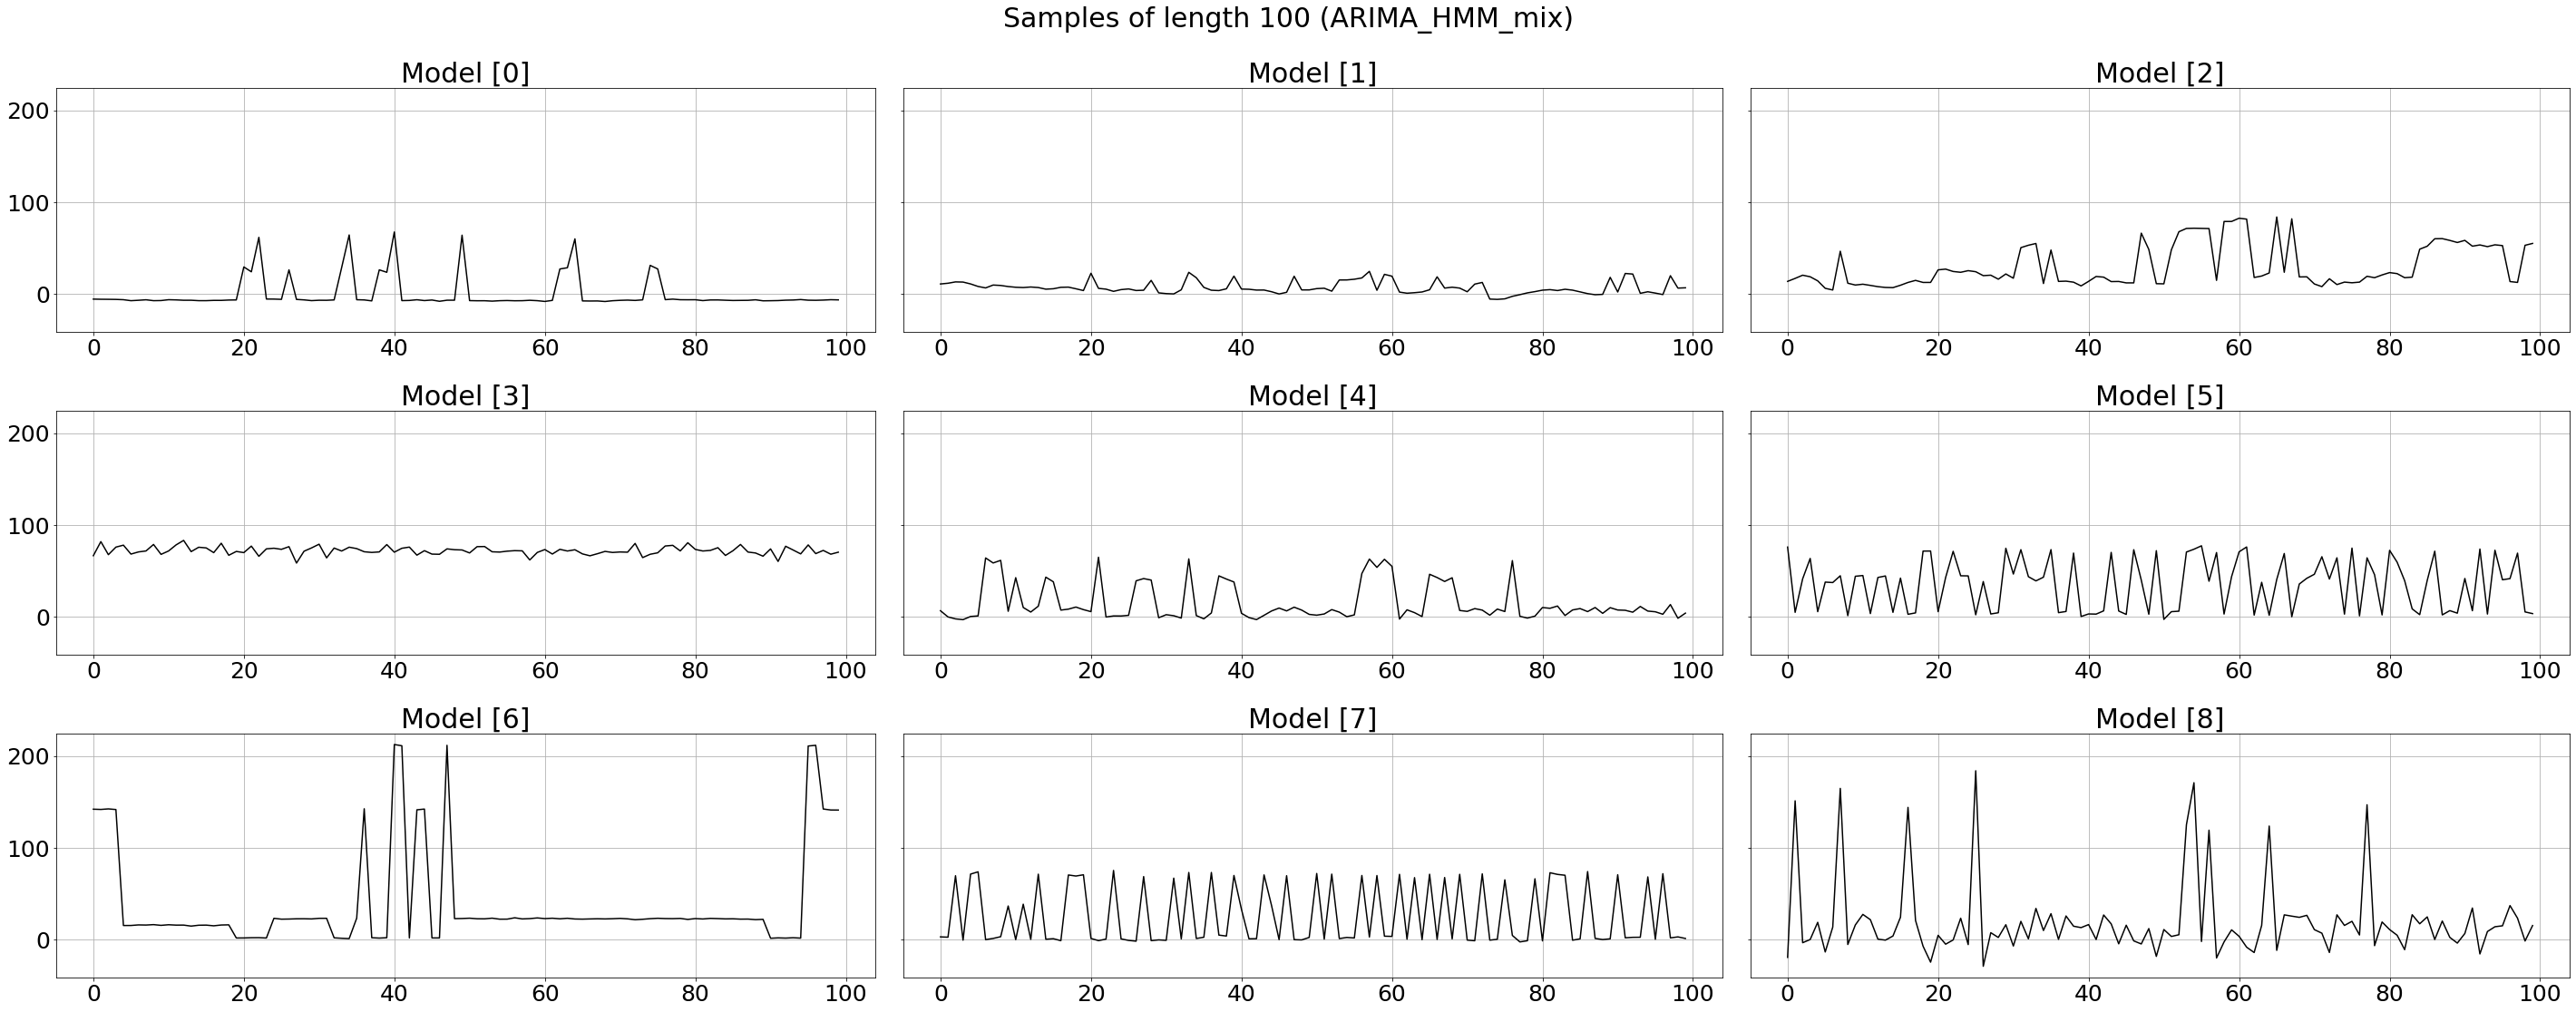

In [36]:
n = 100
plt.rcParams["figure.figsize"] = (40, 16)
plt.rcParams['font.size'] = 25
fig, axes = plt.subplots(3,3, sharey="all")
plt.suptitle(f"Samples of length {n} ({GENERATING_MODEL_NAME})")
for i, ax in enumerate(axes.reshape(-1)):
    m = models_lst[i]
    try:
        X = m.sample(n)
    except Exception as e:
        print(f"Error in model {i}: {e}")
        continue
        
    ax.plot(X, color = "black")
    ax.set_title(f"Model [{i}]")
    ax.grid()

fig.tight_layout()   
plt.savefig(f"./plots/models_{GENERATING_MODEL_NAME}_{time_index}.jpg")
plt.show()

## Generate all data

In [37]:
def generate_data(models_lst: list[ARIMA_HMM_model], samples_per_model: int, max_sample_len: int, min_sample_len: int) -> tuple:
    """Generate data from list of hmm.BaseHMM instances.
    Returns:
        - labels_df: pd.DataFrame | sample_id | true_label | sample_len
        - all_X_samples: a list with generated X samples
    """
    all_X_samples = []
    true_labels = []
    sample_lengths = []
    sample_ids = list(range(samples_per_model*len(models_lst)))
    len_step = (max_sample_len-min_sample_len)//10
    possible_lenghts = range(min_sample_len, max_sample_len + 1, len_step)
    
    for i in range(len(models_lst)):
        model = models_lst[i]
        for j in range(samples_per_model):
            sample_len = np.random.choice(possible_lenghts)
            X = model.sample(sample_len)
            all_X_samples.append(X)
            sample_lengths.append(sample_len)
            true_labels.append(i)

    labels_df = pd.DataFrame({
        "sample_id": sample_ids,
        "true_label": true_labels,
        "sample_len": sample_lengths
    })

    return labels_df, all_X_samples

In [38]:
samples_per_model = N_TRAIN_SAMPLES_PER_MODEL + N_TEST_SAMPLES_PER_MODEL
labels_df, all_X_samples = generate_data(models_lst, samples_per_model, MAX_SAMPLE_LEN, MIN_SAMPLE_LEN)

## Prepare splits

In [39]:
train_samples_ids = []
test_samples_ids = []
for label, sub_df in labels_df.groupby("true_label"):
    train_ids = sub_df.sample(N_TRAIN_SAMPLES_PER_MODEL).index.values
    test_ids = sub_df.drop(train_ids).index.values
    if len(test_ids) != N_TEST_SAMPLES_PER_MODEL:
        raise Exception(f"len(test_ids) {len(test_ids)} != N_TEST_SAMPLES_PER_MODEL {N_TEST_SAMPLES_PER_MODEL}")
    train_samples_ids.extend(train_ids)
    test_samples_ids.extend(test_ids)
    

indices_split = {
    "train_samples_ids": train_samples_ids, 
    "test_samples_ids": test_samples_ids}

indices_splits_lst = [indices_split]
print(len(indices_split["train_samples_ids"]), len(indices_split["test_samples_ids"]))

270 270


In [40]:
data_filename = f"{FILENAME_SUFFIX}_{time_index}.pkl"
output_path = f"{DATA_DIR}/{data_filename}"

metadata = {
    "N_TRAIN_SAMPLES_PER_MODEL": N_TRAIN_SAMPLES_PER_MODEL,
    "N_TEST_SAMPLES_PER_MODEL": N_TEST_SAMPLES_PER_MODEL,
    "MAX_SAMPLE_LEN": MAX_SAMPLE_LEN,
    "MIN_SAMPLE_LEN": MIN_SAMPLE_LEN,
}

data = {
    'generating_model': GENERATING_MODEL_NAME,
    'data_filename': data_filename,
    'time_index': time_index,
    'models_lst': models_lst,
    'labels_df': labels_df,
    'all_X_samples': all_X_samples,
    'indices_splits_lst': indices_splits_lst,
    'metadata': metadata,
    'description': DESCRIPTION
}

with open(output_path, 'wb') as f:
    pickle.dump(data, f)
    print(f"Data saved to {output_path}.")

Data saved to ./generated_data_set2/ARIMA_HMM_mix_data_ntrain30_min50_max150_1659094530.pkl.
